# 1. Setup

In [136]:
# Standard library
import numpy as np
import pandas as pd
from pathlib import Path

# Machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration and utilities
import tomllib
from rich import print

# Set random seed for reproducibility
np.random.seed(42)

In [137]:
# Load configuration
with open('config.toml', 'rb') as f:
    config = tomllib.load(f)

print("✅ Configuration loaded")

# Load dataset
dataset_path = Path('datasets/dataset_raw.csv')
df = pd.read_csv(dataset_path, delimiter=';')

# Normalise column names to snake_case
df.columns = [col.lower().replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_') 
              for col in df.columns]

print(f"📊 Dataset loaded: {df.shape[0]:,} rows × {df.shape[1]:,} columns")

# Create binary target (1=Dropout, 0=Continue)
df['target_binary'] = df['target'].map({'Dropout': 1, 'Graduate': 0, 'Enrolled': 0})

# Remove second semester features (data leakage prevention)
second_sem_cols = [col for col in df.columns if '2nd_sem' in col]
df = df.drop(columns=second_sem_cols)

print(f" - Removed {len(second_sem_cols)} second semester features to prevent data leakage")
print(f" - Final dataset: {df.shape[0]:,} rows × {df.shape[1]:,} columns")

✅ Configuration loaded

📊 Dataset loaded: 4,424 rows × 37 columns

- Removed 6 second semester features to prevent data leakage

- Final dataset: 4,424 rows × 32 columns

In [138]:
def normalise_column_names(df):
    """Normalise DataFrame column names to snake_case format"""
    def to_snake_case(name):
        # Convert to string, strip whitespace, lowercase
        name = str(name).strip().lower()
        # Replace spaces and apostrophes with underscores
        name = name.replace(' ', '_').replace("'", '')
        # Remove special characters
        name = name.replace('(', '').replace(')', '').replace('/', '_')
        name = name.replace('-', '_').replace('.', '_')
        # Clean up multiple underscores
        while '__' in name:
            name = name.replace('__', '_')
        # Remove trailing/leading underscores
        name = name.strip('_')
        return name
    
    df_copy = df.copy()
    df_copy.columns = [to_snake_case(col) for col in df_copy.columns]
    return df_copy

# Re-apply normalisation with apostrophe handling
df = normalise_column_names(df)
print('✅ Column names normalised (apostrophes removed)')


✅ Column names normalised (apostrophes removed)

# 2. Feature Selection

In [139]:
# Keep only selected features
selected_features = [
    'tuition_fees_up_to_date', 'scholarship_holder', 'application_order',
    'admission_grade', 'age_at_enrollment', 'curricular_units_1st_sem_grade'
]

# Add engineered features for parents background
df['parental_higher_education'] = (
    (df['mothers_qualification'].isin(config['parental_features']['higher_education_codes'])) |
    (df['fathers_qualification'].isin(config['parental_features']['higher_education_codes']))
).astype(int)

df['parental_professional_occupation'] = (
    (df['mothers_occupation'].isin(config['parental_features']['professional_occupation_codes'])) |
    (df['fathers_occupation'].isin(config['parental_features']['professional_occupation_codes']))
).astype(int)

selected_features.extend(['parental_higher_education', 'parental_professional_occupation'])

# Create final dataset with selected features
X = df[selected_features]
y = df['target_binary']

print(f'🎯 Selected {len(selected_features)} features for k-NN:')
for feature in selected_features:
    print(f'   • {feature}')

print(f'\n- Final dataset: {X.shape[0]:,} samples, {X.shape[1]} features')
print(f'- Target distribution: {y.value_counts().to_dict()}')

🎯 Selected 8 features for k-NN:

• tuition_fees_up_to_date

• scholarship_holder

• application_order

• admission_grade

• age_at_enrollment

• curricular_units_1st_sem_grade

• parental_higher_education

• parental_professional_occupation

- Final dataset: 4,424 samples, 8 features

- Target distribution: {0: 3003, 1: 1421}

# 3. Train Test Split

In [140]:
# Split the data using config parameters
train_size = config['k-NN_model']['train_size']
stratify_split = config['k-NN_model']['stratify']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=train_size,
    stratify=y if stratify_split else None,
    random_state=42
)

# Calculate percentages
train_pct = int(train_size * 100)
test_pct = 100 - train_pct

print(f'📊 Data split ({train_pct}/{test_pct}):')
print(f'   Training: {X_train.shape[0]:,} samples')
print(f'   Test: {X_test.shape[0]:,} samples')

print(f'\n🎯 Class distribution:')
print(f'   Training: {y_train.value_counts().to_dict()}')
print(f'   Test: {y_test.value_counts().to_dict()}')

# Verify class balance is maintained
train_ratio = y_train.mean()
test_ratio = y_test.mean()
print(f'\n✅ Continuation rate: Train={train_ratio:.3f}, Test={test_ratio:.3f}')

📊 Data split (80/20):

Training: 3,539 samples

Test: 885 samples

🎯 Class distribution:

Training: {0: 2402, 1: 1137}

Test: {0: 601, 1: 284}

✅ Continuation rate: Train=0.321, Test=0.321

# 4. Pipeline

In [141]:
# Define feature types for preprocessing
numeric_features = ['application_order', 'admission_grade', 'age_at_enrollment', 
                   'curricular_units_1st_sem_grade']
binary_features = ['tuition_fees_up_to_date', 'scholarship_holder', 
                  'parental_higher_education', 'parental_professional_occupation']

# Get scaler type from config
scaler_type = config['k-NN_model']['scaler_type']

if scaler_type == 'standard':
    scaler = StandardScaler()
elif scaler_type == 'minmax':
    scaler = MinMaxScaler()
else:
    raise ValueError(f'Unknown scaler type: {scaler_type}')

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, numeric_features),
        ('bin', 'passthrough', binary_features)
    ],
    remainder='drop'
)

print(f'🔧 Preprocessing pipeline created:')
print(f'   Scaler: {scaler_type}')
print(f'   Numeric features ({len(numeric_features)}): {numeric_features}')
print(f'   Binary features ({len(binary_features)}): {binary_features}')

🔧 Preprocessing pipeline created:

Scaler: minmax

Numeric features (4): ['application_order', 'admission_grade', 'age_at_enrollment', 
'curricular_units_1st_sem_grade']

Binary features (4): ['tuition_fees_up_to_date', 'scholarship_holder', 'parental_higher_education', 
'parental_professional_occupation']

# 5. Model Training

In [142]:
# Get hyperparameter range from config
k_range = range(config['k-NN_model']['n_neighbors_range'][0], 
                config['k-NN_model']['n_neighbors_range'][1] + 1, 2)
cv_folds = config['k-NN_model']['cv']

# Create pipeline with preprocessing and k-NN
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

# Define parameter grid
param_grid = {
    'classifier__n_neighbors': k_range,
    'classifier__weights': ['uniform', 'distance']
}

def withdrawal_recall(y_true, y_pred):
    """Calculate recall for withdrawal class (class 1)"""
    cm = confusion_matrix(y_true, y_pred)
    if cm.shape[0] < 2:
        return 0.0
    return cm[1, 1] / (cm[1, 1] + cm[1, 0]) if (cm[1, 1] + cm[1, 0]) > 0 else 0.0

withdrawal_scorer = make_scorer(withdrawal_recall)

# Perform grid search
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42),
    scoring=withdrawal_scorer,
    n_jobs=-1,
    verbose=1
)

print(f'🔍 Starting grid search:')
print(f'   k-values: {list(k_range)}')
print(f'   Weights: {param_grid["classifier__weights"]}')
print(f'   CV folds: {cv_folds}')

# Fit the model
grid_search.fit(X_train, y_train)

print(f'\n✅ Best parameters: {grid_search.best_params_}')
print(f'✅ Best CV score (withdrawal recall): {grid_search.best_score_:.3f}')

🔍 Starting grid search:

k-values: [3, 5, 7, 9, 11, 13, 15, 17, 19]

Weights: ['uniform', 'distance']

CV folds: 10

Fitting 10 folds for each of 18 candidates, totalling 180 fits


✅ Best parameters: {'classifier__n_neighbors': 3, 'classifier__weights': 'uniform'}

✅ Best CV score (withdrawal recall): 0.582

# 6. Evaluation

In [143]:
# Get the best model
best_model = grid_search.best_estimator_

# Make predictions on test set
y_pred = best_model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Calculate specific metrics for withdrawal prediction
withdrawal_recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])  # Recall for withdrawal class (class 1)
continuation_recall = cm[0, 0] / (cm[0, 0] + cm[0, 1])  # Recall for continuation class (class 0)
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1]) if (cm[1, 1] + cm[0, 1]) > 0 else 0

print('📊 Model Performance:')
print(f'   Accuracy: {accuracy:.3f}')
print(f'   Withdrawal recall: {withdrawal_recall:.3f}')
print(f'   Continuation recall: {continuation_recall:.3f}')
print(f'   Precision: {precision:.3f}')

print(f'\n🎯 Confusion Matrix:')
print(f'   Correct continuations: {cm[0, 0]}')
print(f'   False withdrawal predictions: {cm[0, 1]}')
print(f'   Missed withdrawals: {cm[1, 0]}')
print(f'   Correct withdrawals: {cm[1, 1]}')

# Detailed classification report
print(f'\n📈 Classification Report:')
print(classification_report(y_test, y_pred, target_names=['Withdrawal', 'Continuation']))

📊 Model Performance:

Accuracy: 0.815

Withdrawal recall: 0.630

Continuation recall: 0.902

Precision: 0.752

🎯 Confusion Matrix:

Correct continuations: 542

False withdrawal predictions: 59

Missed withdrawals: 105

Correct withdrawals: 179

📈 Classification Report:

precision    recall  f1-score   support

  Withdrawal       0.84      0.90      0.87       601
Continuation       0.75      0.63      0.69       284

    accuracy                           0.81       885
   macro avg       0.79      0.77      0.78       885
weighted avg       0.81      0.81      0.81       885

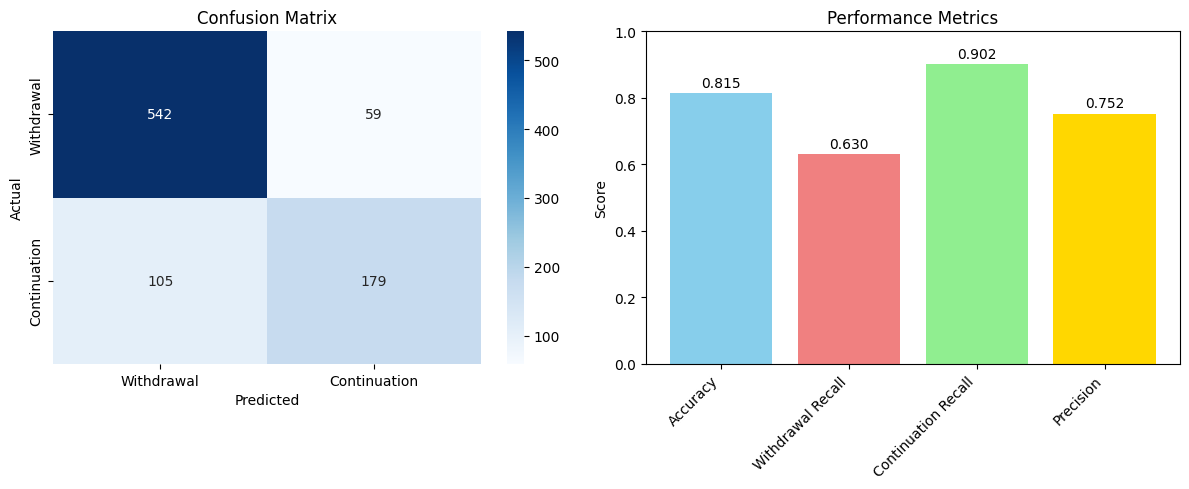

✅ k-NN Model Complete!

Best configuration: k=3, weights=uniform

In [144]:
# Create visualisation of results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['Withdrawal', 'Continuation'],
           yticklabels=['Withdrawal', 'Continuation'],
           ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# Performance Metrics Bar Chart
metrics = ['Accuracy', 'Withdrawal Recall', 'Continuation Recall', 'Precision']
values = [accuracy, withdrawal_recall, continuation_recall, precision]
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']

bars = axes[1].bar(metrics, values, color=colors)
axes[1].set_ylim(0, 1)
axes[1].set_title('Performance Metrics')
axes[1].set_ylabel('Score')

# Add value labels on bars
for bar, value in zip(bars, values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f'✅ k-NN Model Complete!')
print(f'Best configuration: k={grid_search.best_params_["classifier__n_neighbors"]}, '
      f'weights={grid_search.best_params_["classifier__weights"]}')

Getting probability predictions from k-NN model...

Creating Professional Threshold vs Performance Chart for k-NN

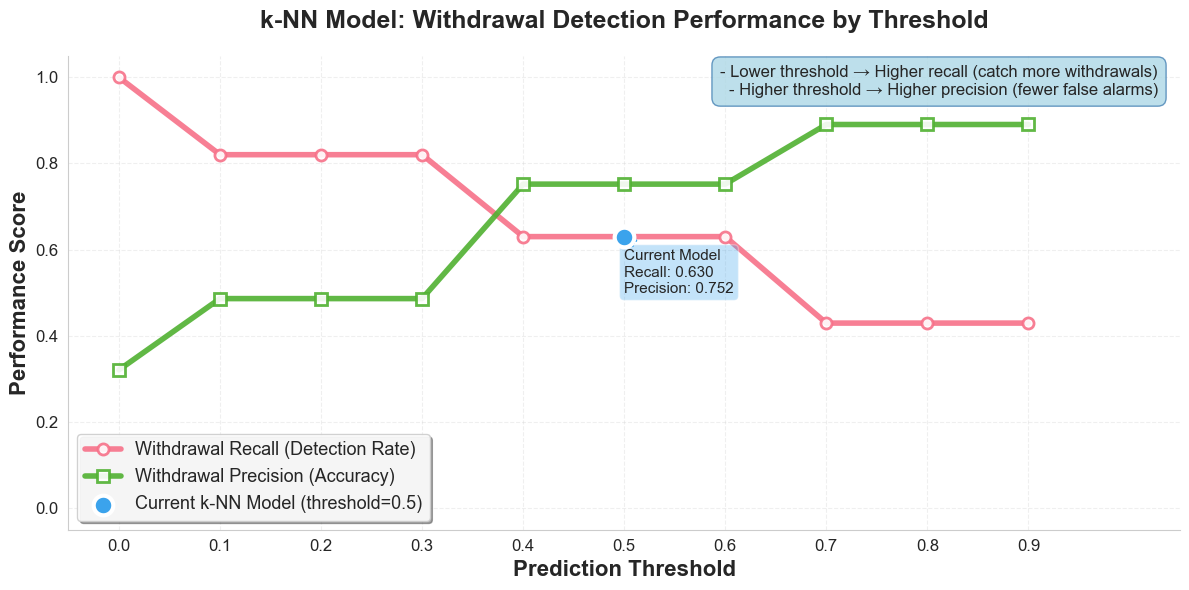

- k-NN THRESHOLD PERFORMANCE ANALYSIS

Threshold  Withdrawal_Recall  Withdrawal_Precision  F1_Score    Status
       0.0               1.00                 0.321     0.486          
       0.1               0.82                 0.486     0.611          
       0.2               0.82                 0.486     0.611          
       0.3               0.82                 0.486     0.611          
       0.4               0.63                 0.752     0.686          
       0.5               0.63                 0.752     0.686 ← CURRENT
       0.6               0.63                 0.752     0.686          
       0.7               0.43                 0.891     0.580          
       0.8               0.43                 0.891     0.580          
       0.9               0.43                 0.891     0.580

- THRESHOLD RECOMMENDATIONS

- Balanced Performance (Best F1)      threshold = 0.4 (F1=0.686)

- Maximum Detection (Best Recall)     threshold = 0.0 (Recall=1.000)

- Minimum False Alarms (Best Precision) threshold = 0.7 (Precision=0.891)

In [150]:
# Set professional seaborn style
sns.set_style('whitegrid')
sns.set_palette('Set2')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# Get probability predictions for threshold analysis
print('Getting probability predictions from k-NN model...')
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Probability of withdrawal (class 1)

# Threshold vs Performance Chart
print('Creating Professional Threshold vs Performance Chart for k-NN')

# Define threshold range (0.0 to 1.0 in 0.1 increments)
thresholds = np.arange(0.0, 1.0, 0.1)

# Store results
withdrawal_precisions = []
withdrawal_recalls = []

# Calculate precision and recall for each threshold
for threshold in thresholds:
    # Make predictions using this threshold
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)
    
    # Calculate confusion matrix
    cm_thresh = confusion_matrix(y_test, y_pred_thresh)
    
    # Handle edge cases where no predictions are made for a class
    if cm_thresh.shape != (2, 2):
        # If threshold is too high/low, some classes might not be predicted
        if threshold >= 1.0:
            # No withdrawals predicted
            withdrawal_recalls.append(0.0)
            withdrawal_precisions.append(0.0)
        else:
            # All predicted as withdrawals
            withdrawal_recalls.append(1.0)
            withdrawal_precisions.append(sum(y_test) / len(y_test))
    else:
        tn, fp, fn, tp = cm_thresh.ravel()
        
        # Withdrawal recall (sensitivity for class 1)
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        
        # Withdrawal precision (positive predictive value for class 1)  
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        
        withdrawal_recalls.append(recall)
        withdrawal_precisions.append(precision)

# Create professional plot with seaborn styling
fig, ax = plt.subplots(figsize=(12, 6))

# Define professional color palette
colors = sns.color_palette('husl', 3)
recall_color = colors[0]  # Blue-ish
precision_color = colors[1]  # Orange-ish
current_color = colors[2]  # Green-ish

# Plot both lines with enhanced styling
ax.plot(thresholds, withdrawal_recalls, 
        color=recall_color, linewidth=4, marker='o', markersize=8, 
        markerfacecolor='white', markeredgecolor=recall_color, markeredgewidth=2,
        label='Withdrawal Recall (Detection Rate)', alpha=0.9)

ax.plot(thresholds, withdrawal_precisions, 
        color=precision_color, linewidth=4, marker='s', markersize=8,
        markerfacecolor='white', markeredgecolor=precision_color, markeredgewidth=2,
        label='Withdrawal Precision (Accuracy)', alpha=0.9)

# Mark current model (0.5 threshold) with enhanced styling
current_idx = 5  # 0.5 is at index 5 in our array
ax.scatter(0.5, withdrawal_recalls[current_idx], s=200, 
          color=current_color, edgecolor='white', linewidth=3, zorder=5,
          label=f'Current k-NN Model (threshold=0.5)')

# Add annotation for current model
ax.annotate(f'Current Model\nRecall: {withdrawal_recalls[current_idx]:.3f}\nPrecision: {withdrawal_precisions[current_idx]:.3f}',
            xy=(0.5, withdrawal_recalls[current_idx]), 
            xytext=(0.5, 0.5), fontsize=11,
            bbox=dict(boxstyle='round,pad=0.3', facecolor=current_color, alpha=0.3),
            arrowprops=dict(arrowstyle='->', color=current_color, lw=2))

# Enhanced formatting
ax.set_xlabel('Prediction Threshold', fontsize=16, fontweight='bold')
ax.set_ylabel('Performance Score', fontsize=16, fontweight='bold')
ax.set_title('k-NN Model: Withdrawal Detection Performance by Threshold', 
             fontsize=18, fontweight='bold', pad=20)

# Customise grid
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Enhanced legend - moved to bottom left
legend = ax.legend(fontsize=13, frameon=True, shadow=True, 
                   fancybox=True, framealpha=0.9, loc='lower left')
legend.get_frame().set_facecolor('white')

# Set limits and ticks
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
ax.set_xticks(thresholds)
ax.set_xticklabels([f'{t:.1f}' for t in thresholds], fontsize=12)
ax.tick_params(axis='y', labelsize=12)

# Add professional text box with guidance - moved to top right to avoid legend
textstr = '''- Lower threshold → Higher recall (catch more withdrawals)
- Higher threshold → Higher precision (fewer false alarms)'''

ax.text(0.98, 0.98, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8,
                 edgecolor='steelblue', linewidth=1))

# Remove top and right spines for cleaner look
sns.despine(ax=ax)

plt.tight_layout()
plt.show()

# Create professional results table
results_df = pd.DataFrame({
    'Threshold': thresholds,
    'Withdrawal_Recall': withdrawal_recalls,
    'Withdrawal_Precision': withdrawal_precisions
})

# Calculate F1 scores
f1_scores = []
for i, threshold in enumerate(thresholds):
    if withdrawal_precisions[i] + withdrawal_recalls[i] > 0:
        f1 = 2 * (withdrawal_precisions[i] * withdrawal_recalls[i]) / (withdrawal_precisions[i] + withdrawal_recalls[i])
    else:
        f1 = 0.0
    f1_scores.append(f1)

results_df['F1_Score'] = f1_scores
results_df = results_df.round(3)

# Add status column
results_df['Status'] = results_df['Threshold'].apply(lambda x: '← CURRENT' if x == 0.5 else '')

# Style the dataframe display
print(' - k-NN THRESHOLD PERFORMANCE ANALYSIS')
print(results_df.to_string(index=False))

# Professional recommendations section
print(' - THRESHOLD RECOMMENDATIONS')

best_f1_idx = np.argmax(f1_scores)
best_recall_idx = np.argmax(withdrawal_recalls)
best_precision_idx = np.argmax(withdrawal_precisions)

recommendations = [
    ('   - Balanced Performance (Best F1)', thresholds[best_f1_idx], f'F1={f1_scores[best_f1_idx]:.3f}'),
    ('   - Maximum Detection (Best Recall)', thresholds[best_recall_idx], f'Recall={withdrawal_recalls[best_recall_idx]:.3f}'),
    ('   - Minimum False Alarms (Best Precision)', thresholds[best_precision_idx], f'Precision={withdrawal_precisions[best_precision_idx]:.3f}')
]

for desc, threshold, metric in recommendations:
    print(f'{desc:<40} threshold = {threshold:.1f} ({metric})')

# Reset matplotlib style to default for subsequent plots
plt.style.use('default')
